In [1]:
all_insertions = '0.5.21.filtered_calls_prosgfp_guts.gff'
FEATURE_DIR = '.'
INSERTION_SET = 'ProsGFP guts'
GENOME_FAI = '../../../reference-data/dmel-all-chromosome-r6.17.fasta.fai'

In [2]:
# Parameters
all_insertions = "../nanopore_heads_combined.bed"
INSERTION_SET = "ProsGFP heads nanopore"


In [3]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pybedtools
from collections import defaultdict
import re
from tempfile import TemporaryDirectory
from adjustText import adjust_text
%matplotlib inline


def despine(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax


def set_shared_ylabel(a, ylabel, labelpad = 0.01):
    """Set a y label shared by multiple axes
    Parameters
    ----------
    a: list of axes
    ylabel: string
    labelpad: float
        Sets the padding between ticklabels and axis label"""

    f = a[0].get_figure()
    f.canvas.draw() #sets f.canvas.renderer needed below

    # get the center position for all plots
    top = a[0].get_position().y1
    bottom = a[-1].get_position().y0

    # get the coordinates of the left side of the tick labels 
    x0 = 1
    for at in a:
        at.set_ylabel('') # just to make sure we don't and up with multiple labels
        bboxes, _ = at.yaxis.get_ticklabel_extents(f.canvas.renderer)
        bboxes = bboxes.inverse_transformed(f.transFigure)
        xt = bboxes.x0
        if xt < x0:
            x0 = xt
    tick_label_left = x0

    # set position of label
    a[-1].set_ylabel(ylabel)
    a[-1].yaxis.set_label_coords(tick_label_left - labelpad,(bottom + top)/2, transform=f.transFigure)


def get_figsize_ncols_nrows(n, ncols=None, nrows=None, per_ax_size=5):
    if ncols:
        nrows = int(n / ncols)
        if float(n) / ncols != nrows:
            nrows += 1
    else:
        ncols = int(n / nrows) + 1
        if float(n) / nrows != ncols:
            ncols += 1
    return (nrows * per_ax_size, ncols * per_ax_size), ncols, nrows


# fig, ax = plt.subplots(figsize=(10, 10))
def plot_volcano(df, insertion_label, tissue, p_value_cutoff=10, imageext='pdf'):
    df = df[(df['log2_enrichment'] > -10) & (df['log2_enrichment'] < 10)]
    df['Significant'] = (df['-log10 p-value'] > p_value_cutoff)
    g = sns.lmplot(x='log2_enrichment', y='-log10 p-value', hue='Significant', data=df, fit_reg=False, size=10, aspect=1.6)
    ax = plt.gca()
    for index, row in df.iterrows():
        texts = []
        if row['-log10 p-value'] > p_value_cutoff:
            x = row['log2_enrichment']
            y = row['-log10 p-value']
            text = row['Assay Factor']
            texts.append(ax.text(x, y, text, horizontalalignment='left', size='small', color='black'))
            adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1), force_text=(0.2, 1))
    title = "Volcanoplot (%s) and somatic %s insertions" % (tissue, insertion_label)
    ax.set_title(title)
    despine(ax)
    ax.figure.savefig("%s - %s.%s" % (INSERTION_SET, title, imageext))
    

def get_enrichments(query, target_dir, subset=None):
    genomic_features = [os.path.join(target_dir, p) for p in os.listdir(target_dir) if p.endswith('.gtf')]
    bedtool = pybedtools.BedTool(query).sort()
    if subset:
        df = bedtool.to_dataframe()
        if 'feature' in df.columns:
            column = 'feature'
        elif 'name' in df.columns:
            column = 'name'
        else:
            raise AssertionError("Dataset doesn't seem to be GFF or BED.")
        bedtool = pybedtools.BedTool.from_dataframe(df[df[column] == subset])

    result = defaultdict(dict)
    for f in genomic_features:
        basename = os.path.basename(f)
        with open(f) as b:
            r = bedtool.fisher(b, g=GENOME_FAI)
        result[basename]['ratio'] = r.ratio
        result[basename]['p_left'] = r.left_tail
        result[basename]['p_right'] = r.right_tail
        result[basename]['two_tail'] = r.two_tail
        result[basename]['overlap'] = r.table['in -a']['in -b']

    df = pd.DataFrame.from_dict(result).transpose()
    df['index'] = [s.split('_')[0] for s in df.index]
    df['log2_enrichment'] = np.log2(df['ratio'] + 0.00001)
    # df = df[(df['log2_enrichment'] > -10) & (df['log2_enrichment'] < 10)]
    df['-log10 p-value'] = -np.log10(df['two_tail'])
    k = ['Assay Factor', 'genotype', 'Tissue', 'Type', 'replicate', 'enriched', 'project_id']
    d = {f: dict(zip(k, f.split('.')[0].split('_'))) for f in df.index}
    full_df = pd.DataFrame.from_dict(d).transpose().merge(df, right_index=True, left_index=True)
    full_df['Assay Factor'] = full_df['Assay Factor'].str.replace('RNA-polymerase-II-CTD-repeat-YSPTSPS', 'PolII')
    full_df['Assay Factor'] = full_df['Assay Factor'].str.replace('RNA-polymerase-II', 'PolII')
    return full_df


def mean_for_group(df):
    df = df.groupby(['Assay Factor', 'genotype', 'Tissue', 'enriched', 'overlap']).agg({'-log10 p-value': np.mean, 'log2_enrichment': np.mean}).reset_index()
    df.index = df['Assay Factor']
    return df


def enriched_for_tissue(df, tissue='Adult', genotype='wt'):
    return df[(df['genotype'] == genotype) & (df['Tissue'] == tissue) & (df['enriched'] == 'enriched')]


def plot_heatmap_and_barchart(df, insertion_label='rover', tissue='Adult', imgext='pdf'):
    palette = sns.cubehelix_palette(50, hue=0.05, rot=0, light=2, dark=0, as_cmap=True)
    df = df[df.log2_enrichment != np.inf]
    sign = (df['log2_enrichment'] > 0).astype(int)
    sign[sign == 0] = -1
    df['signed-log10 p-value'] = df['-log10 p-value'] * sign
    df = df.sort_values(['signed-log10 p-value'], ascending=False)
    to_plot = df[['-log10 p-value']]
    height = 0.2 * len(to_plot)
    fig = plt.figure(figsize=(5, 2), constrained_layout=True)
    widths = [1, 4]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])

    sns.heatmap(to_plot, center=0, annot=True, cbar=False, cmap=palette, ax=ax1)
    to_plot = df[['log2_enrichment', '-log10 p-value']]
    to_plot['Assay Factor'] = to_plot.index
    sns.barplot(y='Assay Factor', x='log2_enrichment', data=to_plot, ax=ax2, color='k')
    ax2.set_yticklabels('')
    ax2.set_ylabel('')
    ax2.set_yticks([])
    despine(ax2)
    title = "Correlation of %s insertions with gene tracks for %s" % (insertion_label, tissue)
    fig.suptitle(title)
    fig.savefig("%s - %s.%s" % (INSERTION_SET, title, imgext), bbox_inches='tight')

In [4]:
all_insertions_df = get_enrichments(query=all_insertions, target_dir=FEATURE_DIR)
copia_df = get_enrichments(query=all_insertions, target_dir=FEATURE_DIR, subset='copia')
rover_df = get_enrichments(query=all_insertions, target_dir=FEATURE_DIR, subset='rover')
i_element_df = get_enrichments(query=all_insertions, target_dir=FEATURE_DIR, subset='I-element')
two_nine_seven_df = get_enrichments(query=all_insertions, target_dir=FEATURE_DIR, subset='297')

/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


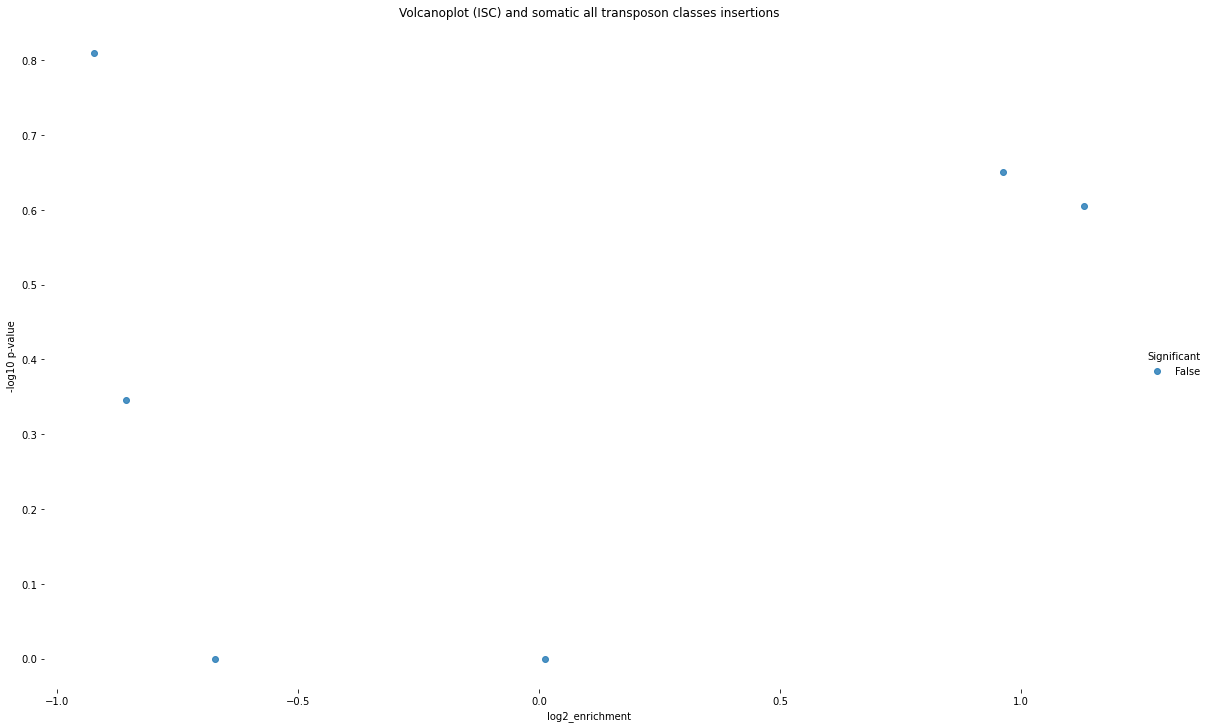

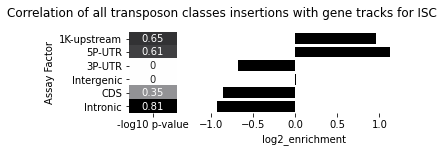

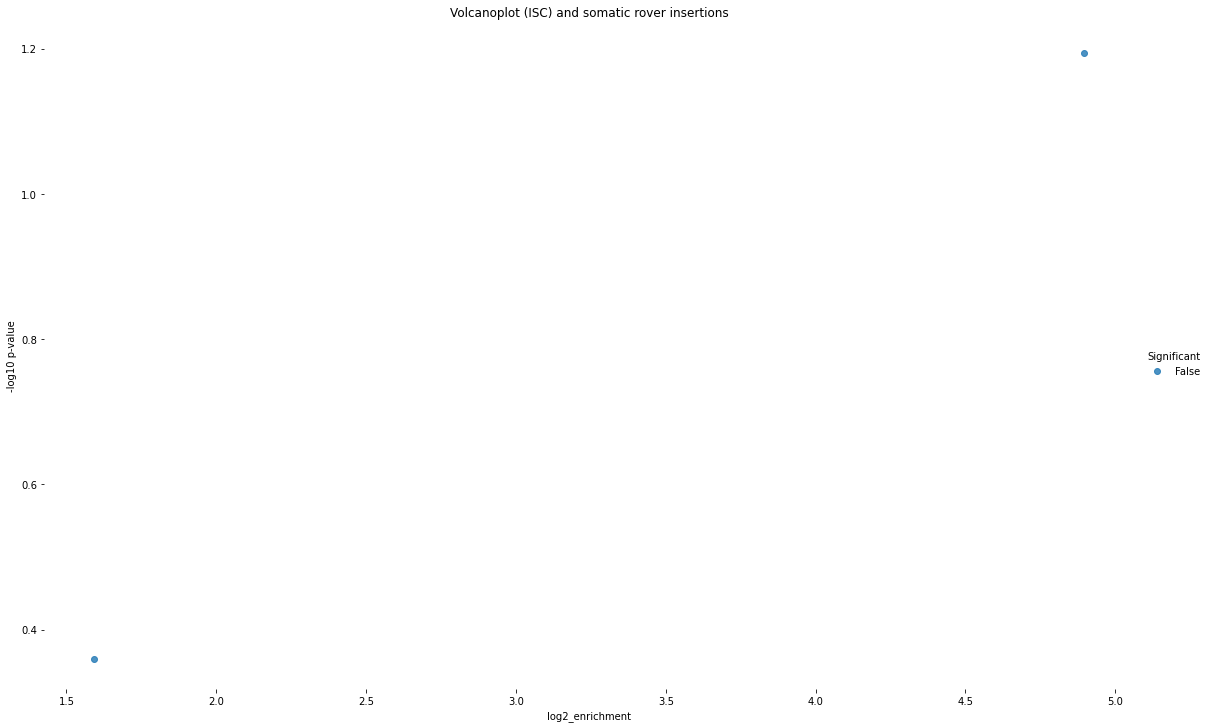

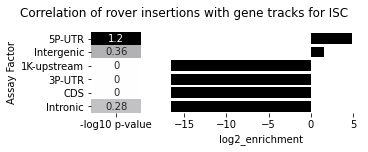

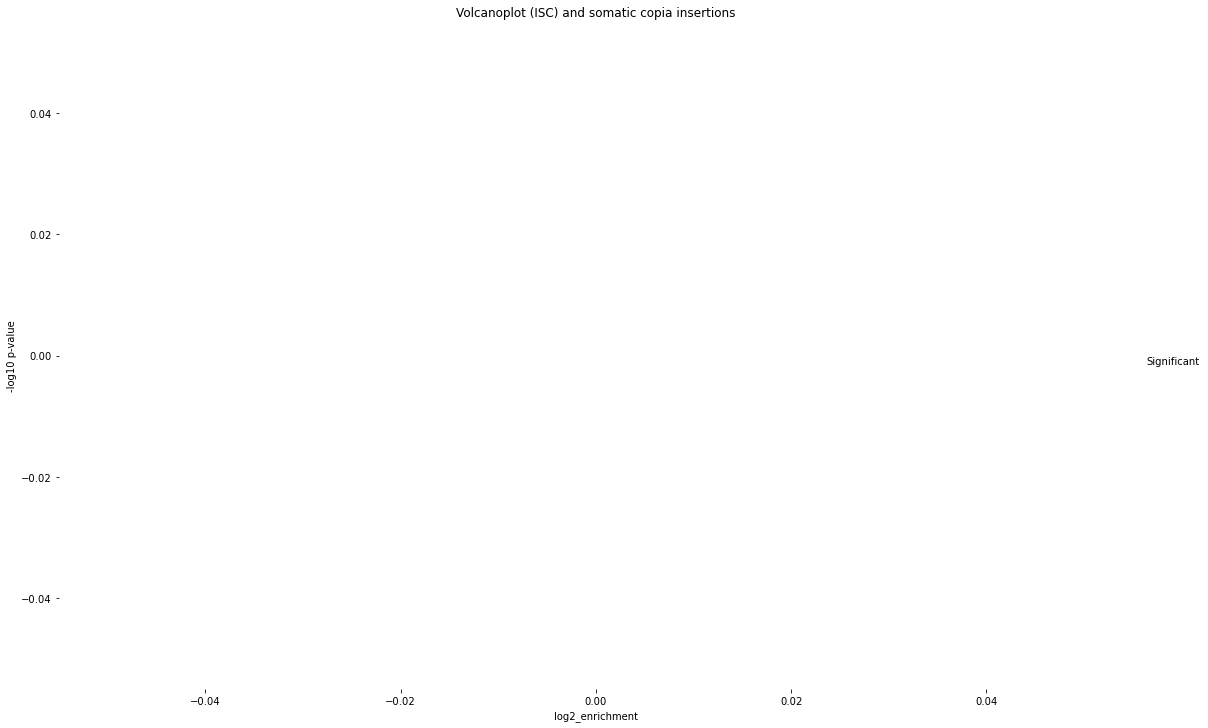

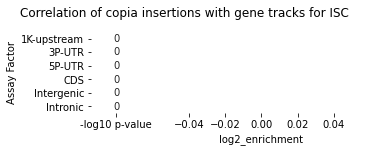

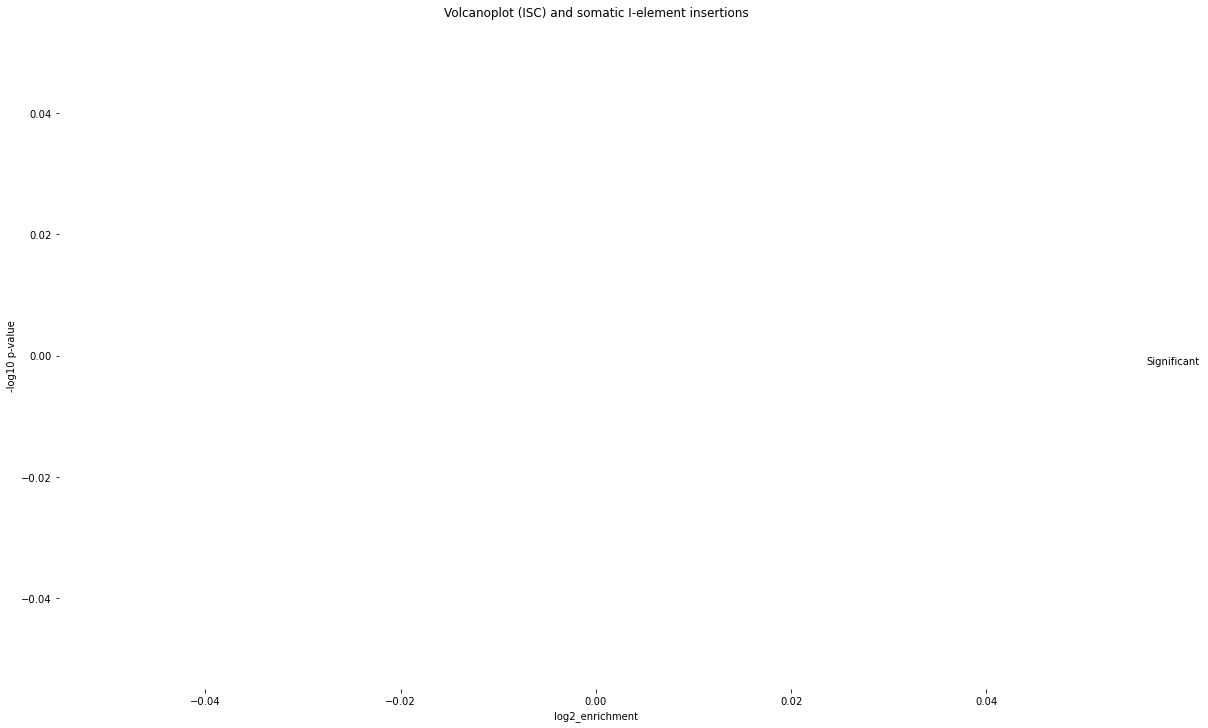

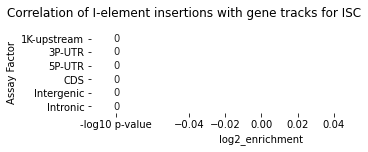

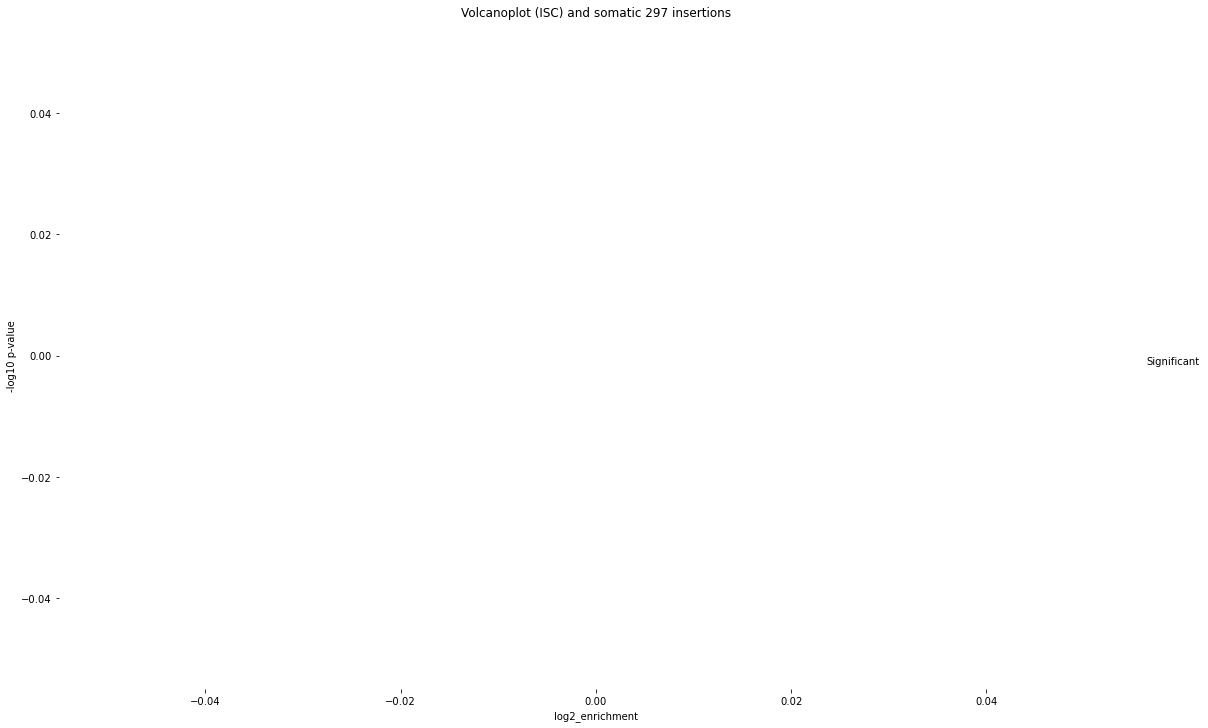

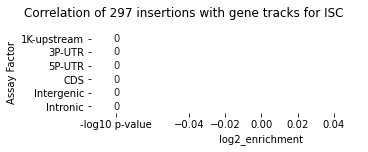

In [5]:
data_frames = [all_insertions_df, rover_df, copia_df, i_element_df, two_nine_seven_df]
insertions_labels = ['all transposon classes', 'rover', 'copia', 'I-element', '297']
tissues = ['ISC']

for insertion_label, df in zip(insertions_labels, data_frames):
    for tissue in tissues:
        df['Tissue'] = tissue
        df['genotype'] = 'wt'
        df['enriched'] = 'enriched'
        enriched_df = enriched_for_tissue(mean_for_group(df), tissue=tissue)
        if len(enriched_df) < 5:
            continue
        title = "Correlation of %s insertions with gene tracks for %s" % (insertion_label, tissue)
        enriched_df.to_csv("%s - %s.tsv" % (INSERTION_SET, title), sep='\t', index=None)
        plot_volcano(enriched_df, insertion_label, tissue, p_value_cutoff=5)
        plot_heatmap_and_barchart(enriched_df, insertion_label=insertion_label, tissue=tissue)